In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression as LR
import pickle 
import os

import sklearn.metrics

In [2]:
def create_mlp(features = int, multiples = list, dropout = 0, name= 'multilayer_nn'):
    input_layer = tf.keras.Input((features))

    for n, hl in enumerate(multiples):

        if n == 0: x = tf.keras.layers.Dense(hl*features)(input_layer)
        else: x = tf.keras.layers.Dense(hl*features)(x)

        x = tf.keras.layers.LayerNormalization()(x)

        if n != len(multiples) -1:
            x = tf.keras.layers.LeakyReLU(0.15)(x)
            x = tf.keras.layers.Dropout(dropout)(x)

    xs = tf.keras.layers.Dense(multiples[-1]*features)(input_layer)
    xs = tf.keras.layers.LayerNormalization()(xs)

    x = tf.keras.layers.Add()([x, xs])
    x = tf.keras.layers.LeakyReLU(0.5)(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    x = tf.keras.layers.Dense(6)(x)

    return tf.keras.models.Model(inputs=input_layer, outputs=x, name=name)


### 1. Loading files and preprocessing

In [3]:
directorio = './Jul_16_00_28_2023/'

In [4]:
hfxrd = np.load(directorio + 'hf_0100.npy')
y = np.load('./latpars.npy')

In [5]:
db = pd.read_csv('./db_peaks.csv')

In [6]:
for row in range(db.shape[0]):    
    db.at[row,'name'] = db['name'][row][:7]

In [7]:
dftest = pd.read_csv(directorio + 'dftest.csv')
dftraval = pd.read_csv(directorio + 'dftraval.csv')

for row in range(dftest.shape[0]):
    dftest.at[row, 'name'] = dftest['name'][row][:7]
    
for row in range(dftraval.shape[0]):
    dftraval.at[row, 'name'] = dftraval['name'][row][:7]

ntest = dftest.shape[0]//4
ntraval = dftraval.shape[0]//4

dftest = dftest.iloc[:ntest,:].reset_index(drop=True)
dftraval = dftraval.iloc[:ntraval,:].reset_index(drop=True)

idxtraval = [i for i in db.loc[db.name.isin([i.split('_')[0] for i in dftraval.name.values])].index]
idxtest = [i for i in db.loc[db.name.isin([i.split('_')[0] for i in dftest.name.values])].index]

hftest = hfxrd[idxtest]
hftraval = hfxrd[idxtraval]

ytest = y[idxtest]
ytraval = y[idxtraval]

In [8]:
sgdiccio = pd.read_csv('./sgnum_cif.csv')
sgdiccio = {k:v for k,v in zip(sgdiccio.cif.values, sgdiccio.sgnum.values)}

dbtest = db.take(idxtest).reset_index(drop=True)
dbtraval = db.take(idxtraval).reset_index(drop=True)

dbtest['sgnum'] = [sgdiccio.get(int(i), None) for i in dbtest.name.values]
dbtraval['sgnum'] = [sgdiccio.get(int(i), None) for i in dbtraval.name.values]

In [9]:
cs = dict()

for n in range(1,231):
    
    if n <= 2: cs[n]  = 0;
    elif 2 < n <=15: cs[n] = 1;
    elif 15 < n <=74: cs[n] = 2;
    elif 74 < n <=142: cs[n] = 3;
    elif 142 < n <=167: cs[n] = 4;
    elif 167 < n <=194: cs[n] = 5;
    elif 194 < n <=230: cs[n] = 6;
        

In [10]:
dbtest['cs'] = [cs.get(i, None) for i in dbtest.sgnum.values]
dbtraval['cs'] = [cs.get(i, None) for i in dbtraval.sgnum.values]

We only use the extracted features after processing the diffraction patterns

In [11]:
hftest = hftest[:,:-96]
hftraval = hftraval[:,:-96]

In [12]:
newpath = './om_revision/' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

### 2. Creating a set of orthonormal vectors to represent the crystal systems and the space groups

Each crystal system will be represented as a 7-dimensional vector. We fix that length to have a 391-dimensional vector after adding the extracted features.

In [13]:
orthoset = scipy.stats.ortho_group.rvs(7, random_state=3451)
np.save(newpath + 'crystal_system_orthonormal', orthoset)
csos_test = orthoset[dbtest.cs.values]
csos_traval = orthoset[dbtraval.cs.values]

Each space group will be represented as a 230-dimensional vector.

In [14]:
sgoset = scipy.stats.ortho_group.rvs(230, random_state=3451)
np.save(newpath + 'space_group_orthonormal', sgoset)
sgos_traval = sgoset[dbtraval.sgnum.values-1]
sgos_test = sgoset[dbtest.sgnum.values-1]

In [15]:
diccio_ptest = dict()
models_diccio = dict()

### 3. Linear regression with the raw extracted features

In [16]:
reg = LR().fit(hftraval, ytraval)
ptest = reg.predict(hftest)
diccio_ptest['lr-xrd'] = ptest
models_diccio['lr-xrd'] = reg
rmse = ((ptest[:,:3] - ytest[:,:3])**2).mean()**0.5
cover = (((ptest[:,:3] - ytest[:,:3])**2).mean(axis=1)**0.5 <= 2*rmse).sum()/ytest.shape[0]

In [17]:
print('rmse:', rmse)
print('assessement within two rmse:', cover)

rmse: 2.531996558763816
assessement within two rmse: 0.9596221043095639


In [18]:
sklearn.metrics.r2_score(ytest, ptest, multioutput='raw_values')

array([0.43471173, 0.45257853, 0.72225449, 0.13240552, 0.08128325,
       0.12037697])

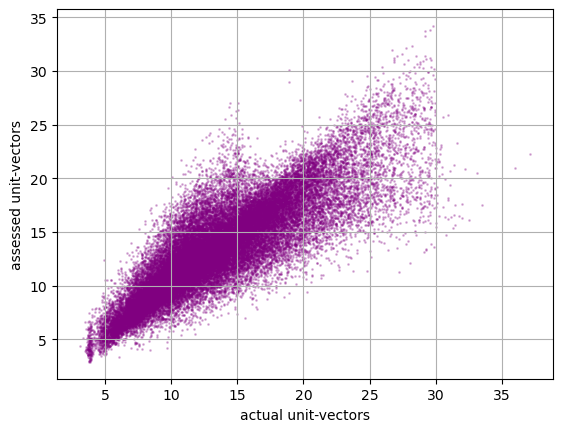

In [19]:
plt.figure()
plt.scatter(ytest[:,:3], ptest[:,:3], s=1, color='purple', alpha=0.25)
plt.xlabel('actual unit-vectors')
plt.ylabel('assessed unit-vectors')
plt.grid()
plt.show()

#### 3.1 ANN model

In [20]:
features = hftraval.shape[-1]

In [21]:
multiples = [3,2]

In [22]:
modelo_xrd = create_mlp(features = features, multiples = multiples, dropout = 0.5, name='mlp_xrd')
modelo_xrd.summary()

Model: "mlp_xrd"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 1152)         443520      ['input_1[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 1152)        2304        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 1152)         0           ['layer_normalization[0][0]

In [23]:
modelo_xrd.compile(loss='logcosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

C:\Users\igofo\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adamax.py:99: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [24]:
epochs = 50
batch_size = 64
verbose=1
saveas = 'new_model_xrd'

Epoch 1/50
3209/3209 [==============================] - 57s 15ms/step - loss: 0.6300 - mean_squared_error: 3.2138 - val_loss: 0.5625 - val_mean_squared_error: 3.1646
Epoch 2/50
3209/3209 [==============================] - 45s 14ms/step - loss: 0.4904 - mean_squared_error: 2.5410 - val_loss: 0.5294 - val_mean_squared_error: 3.1542
Epoch 3/50
3209/3209 [==============================] - 31s 10ms/step - loss: 0.4633 - mean_squared_error: 2.4060 - val_loss: 0.5152 - val_mean_squared_error: 3.1087
Epoch 4/50
3209/3209 [==============================] - 46s 14ms/step - loss: 0.4481 - mean_squared_error: 2.3250 - val_loss: 0.5128 - val_mean_squared_error: 3.0797
Epoch 5/50
3209/3209 [==============================] - 33s 10ms/step - loss: 0.4387 - mean_squared_error: 2.2748 - val_loss: 0.5086 - val_mean_squared_error: 3.1749
Epoch 6/50
3209/3209 [==============================] - 32s 10ms/step - loss: 0.4297 - mean_squared_error: 2.2213 - val_loss: 0.5099 - val_mean_squared_error: 3.1300
Epoc

3209/3209 [==============================] - 45s 14ms/step - loss: 0.3181 - mean_squared_error: 1.6218 - val_loss: 0.4754 - val_mean_squared_error: 3.1662


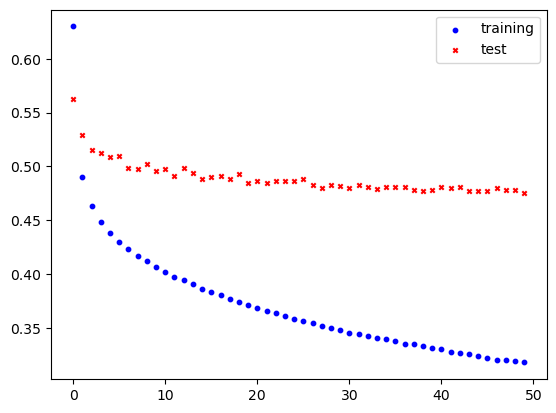

In [25]:
modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_xrd.fit(hftraval,ytraval, validation_data=(hftest,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log))
dataframe1 = pd.DataFrame(data=mat.T)
dataframe1.to_csv(newpath + str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.T.shape[0]), mat.T[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.T.shape[0]), mat.T[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

In [26]:
ptestnn = modelo_xrd.predict(hftest)
diccio_ptest['ann-xrd'] = ptestnn

483/483 [==============================] - 4s 7ms/step


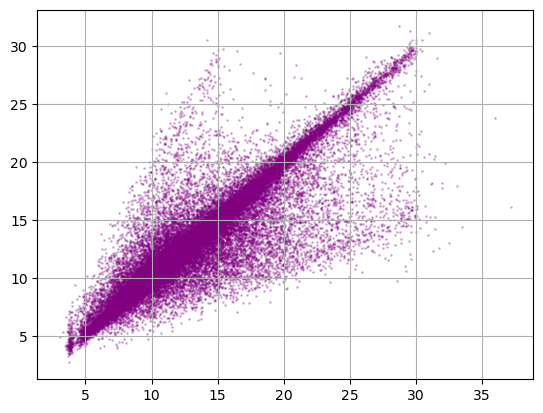

In [27]:
plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=1, color='purple', alpha=0.25)
plt.grid()
plt.show()

In [28]:
rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5

In [29]:
rmse

2.5114306315268937

In [30]:
(((ptestnn[:,:3] - ytest[:,:3])**2).mean(axis=1)**0.5 <= 2*rmse).sum()/ytest.shape[0]

0.9223502005953151

In [31]:
sklearn.metrics.r2_score(ytest, ptestnn, multioutput='raw_values')

array([0.42349704, 0.48695122, 0.75635016, 0.12937118, 0.06295518,
       0.1279838 ])

In [32]:
models_diccio['ann-xrd'] = modelo_xrd

In [33]:
modelo_xrd.save(newpath + 'new_model_xrd.h5')

### 4. Linear regression after concatenation of the extracted features with the orthonormal of vectors (crystal systems)

In [34]:
xtest = np.concatenate((hftest, csos_test), axis=-1)
xtraval = np.concatenate((hftraval, csos_traval), axis=-1)

In [35]:
reg_cs = LR().fit(xtraval, ytraval)
ptest = reg_cs.predict(xtest)
diccio_ptest['lr-cs'] = ptest
models_diccio['lr-cs'] = reg_cs
rmse = ((ptest[:,:3] - ytest[:,:3])**2).mean()**0.5
cover = (((ptest[:,:3] - ytest[:,:3])**2).mean(axis=1)**0.5 <= 2*rmse).sum()/ytest.shape[0]

In [36]:
print('rmse:', rmse)
print('assessement within two rmse:', cover)

rmse: 1.9559576793503397
assessement within two rmse: 0.9540572020188948


In [38]:
sklearn.metrics.r2_score(ytest, ptest, multioutput='raw_values')

array([0.70749243, 0.62561541, 0.7555458 , 0.16555004, 0.10608336,
       0.20787173])

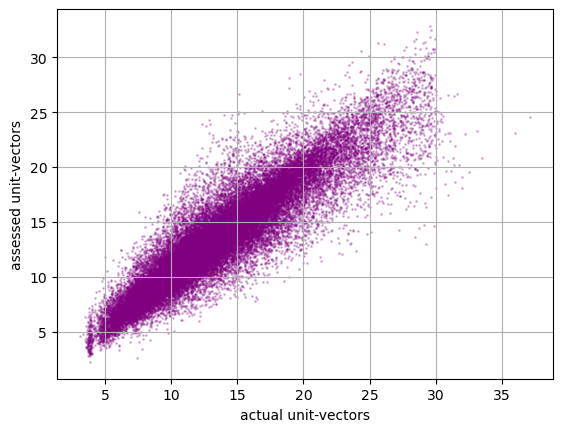

In [39]:
plt.figure()
plt.scatter(ytest[:,:3], ptest[:,:3], s=1, color='purple', alpha=0.25)
plt.xlabel('actual unit-vectors')
plt.ylabel('assessed unit-vectors')
plt.grid()
plt.show()

#### 4.1 ANN model

In [40]:
features = xtraval.shape[-1]

In [41]:
multiples = [3,2]

In [42]:
modelo_cs = create_mlp(features = features, multiples = multiples, dropout = 0.5, name='mlp_cs')
modelo_cs.summary()

Model: "mlp_cs"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 391)]        0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 1173)         459816      ['input_2[0][0]']                
                                                                                                  
 layer_normalization_3 (LayerNo  (None, 1173)        2346        ['dense_4[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_2 (LeakyReLU)      (None, 1173)         0           ['layer_normalization_3[0][0

In [43]:
modelo_cs.compile(loss='logcosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

C:\Users\igofo\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adamax.py:99: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [44]:
epochs = 50
batch_size = 64
verbose=1
saveas = 'new_model_crystal_system'

Epoch 1/50
3209/3209 [==============================] - 44s 13ms/step - loss: 0.5106 - mean_squared_error: 2.2653 - val_loss: 0.3951 - val_mean_squared_error: 1.8190
Epoch 2/50
3209/3209 [==============================] - 33s 10ms/step - loss: 0.3499 - mean_squared_error: 1.4393 - val_loss: 0.3453 - val_mean_squared_error: 1.6072
Epoch 3/50
3209/3209 [==============================] - 45s 14ms/step - loss: 0.3117 - mean_squared_error: 1.2538 - val_loss: 0.3311 - val_mean_squared_error: 1.5744
Epoch 4/50
3209/3209 [==============================] - 44s 14ms/step - loss: 0.2935 - mean_squared_error: 1.1704 - val_loss: 0.3153 - val_mean_squared_error: 1.5390
Epoch 5/50
3209/3209 [==============================] - 32s 10ms/step - loss: 0.2812 - mean_squared_error: 1.1123 - val_loss: 0.3080 - val_mean_squared_error: 1.4903
Epoch 6/50
3209/3209 [==============================] - 32s 10ms/step - loss: 0.2727 - mean_squared_error: 1.0712 - val_loss: 0.3048 - val_mean_squared_error: 1.4819
Epoc

3209/3209 [==============================] - 33s 10ms/step - loss: 0.1821 - mean_squared_error: 0.6802 - val_loss: 0.2736 - val_mean_squared_error: 1.4074


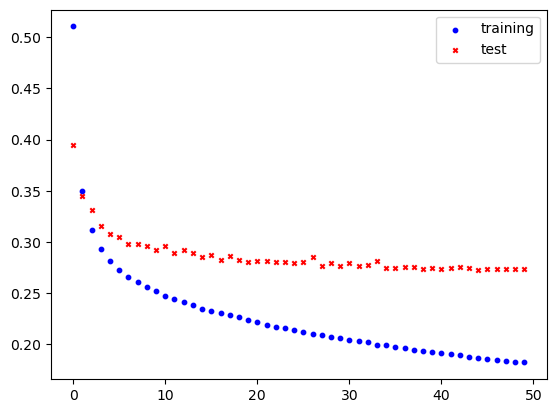

In [45]:
modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_cs.fit(xtraval,ytraval, validation_data=(xtest,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log))
dataframe1 = pd.DataFrame(data=mat.T)
dataframe1.to_csv(newpath + str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.T.shape[0]), mat.T[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.T.shape[0]), mat.T[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

In [46]:
ptestnn = modelo_cs.predict(xtest)
diccio_ptest['ann-cs'] = ptestnn

483/483 [==============================] - 3s 6ms/step


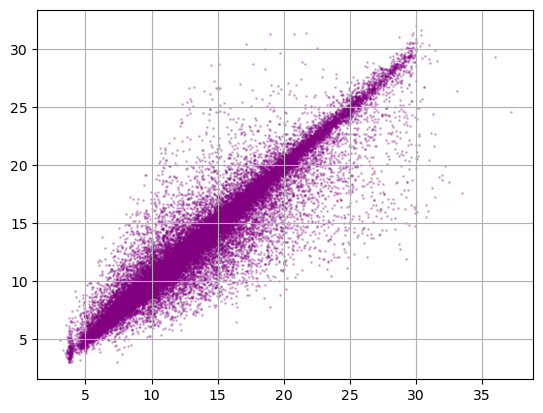

In [47]:
plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=1, color='purple', alpha=0.25)
plt.grid()
plt.show()

In [48]:
rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5

In [49]:
rmse

1.6707085950747718

In [50]:
(((ptestnn[:,:3] - ytest[:,:3])**2).mean(axis=1)**0.5 <= 2*rmse).sum()/ytest.shape[0]

0.9339976705060179

In [51]:
sklearn.metrics.r2_score(ytest, ptestnn, multioutput='raw_values')

array([0.80076507, 0.70827551, 0.80232489, 0.12974121, 0.11244569,
       0.24458821])

In [52]:
models_diccio['ann-cs'] = modelo_cs

### 5. Linear regression after concatenation of the extracted features with the orthonormal of vectors (space groups)

In [53]:
xtest = np.concatenate((hftest, sgos_test), axis=-1)
xtraval = np.concatenate((hftraval, sgos_traval), axis=-1)

In [54]:
reg_sg = LR().fit(xtraval, ytraval)
ptest = reg_sg.predict(xtest)
models_diccio['lr-sg'] = reg_sg
diccio_ptest['lr-sg'] = ptest
rmse = ((ptest[:,:3] - ytest[:,:3])**2).mean()**0.5
cover = (((ptest[:,:3] - ytest[:,:3])**2).mean(axis=1)**0.5 <= 2*rmse).sum()/ytest.shape[0]

In [55]:
print('rmse:', rmse)
print('assessement within two rmse:', cover)

rmse: 1.6681807469346388
assessement within two rmse: 0.9564514041672059


In [56]:
sklearn.metrics.r2_score(ytest, ptest, multioutput='raw_values')

array([0.79314076, 0.73720615, 0.78653809, 0.17443304, 0.10719825,
       0.22837208])

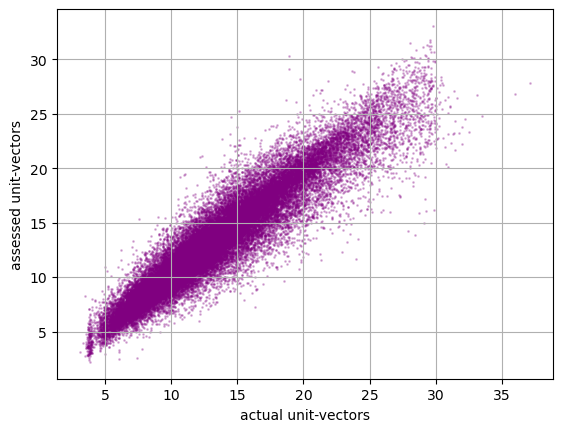

In [57]:
plt.figure()
plt.scatter(ytest[:,:3], ptest[:,:3], s=1, color='purple', alpha=0.25)
plt.xlabel('actual unit-vectors')
plt.ylabel('assessed unit-vectors')
plt.grid()
plt.show()

#### 5.1 NN model

In [58]:
features = xtraval.shape[-1]

In [59]:
multiples = [3,2]

In [60]:
modelo_sg = create_mlp(features = features, multiples = multiples, dropout = 0.5, name='sg_mlp')
modelo_sg.summary()

Model: "sg_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 614)]        0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 1842)         1132830     ['input_3[0][0]']                
                                                                                                  
 layer_normalization_6 (LayerNo  (None, 1842)        3684        ['dense_8[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 1842)         0           ['layer_normalization_6[0][0

In [61]:
modelo_sg.compile(loss='logcosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

C:\Users\igofo\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adamax.py:99: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [62]:
epochs = 50
batch_size = 64
verbose=1
saveas = 'new_model_space_group'

Epoch 1/50
3209/3209 [==============================] - 30s 9ms/step - loss: 0.4126 - mean_squared_error: 1.6293 - val_loss: 0.2988 - val_mean_squared_error: 1.2158
Epoch 2/50
3209/3209 [==============================] - 30s 9ms/step - loss: 0.2540 - mean_squared_error: 0.9044 - val_loss: 0.2650 - val_mean_squared_error: 1.0848
Epoch 3/50
3209/3209 [==============================] - 29s 9ms/step - loss: 0.2247 - mean_squared_error: 0.7801 - val_loss: 0.2429 - val_mean_squared_error: 1.0145
Epoch 4/50
3209/3209 [==============================] - 30s 9ms/step - loss: 0.2101 - mean_squared_error: 0.7211 - val_loss: 0.2393 - val_mean_squared_error: 0.9988
Epoch 5/50
3209/3209 [==============================] - 30s 9ms/step - loss: 0.2010 - mean_squared_error: 0.6848 - val_loss: 0.2258 - val_mean_squared_error: 0.9620
Epoch 6/50
3209/3209 [==============================] - 29s 9ms/step - loss: 0.1945 - mean_squared_error: 0.6596 - val_loss: 0.2345 - val_mean_squared_error: 0.9635
Epoch 7/50

3209/3209 [==============================] - 29s 9ms/step - loss: 0.1276 - mean_squared_error: 0.4141 - val_loss: 0.1945 - val_mean_squared_error: 0.8634


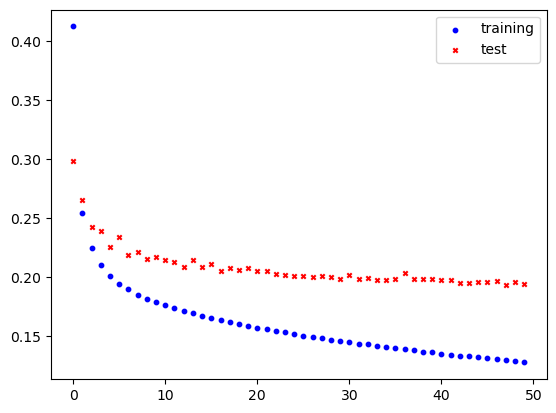

In [63]:
modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_sg.fit(xtraval,ytraval, validation_data=(xtest,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log))
dataframe1 = pd.DataFrame(data=mat.T)
dataframe1.to_csv(newpath + str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.T.shape[0]), mat.T[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.T.shape[0]), mat.T[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

In [64]:
ptestnn = modelo_sg.predict(xtest)
diccio_ptest['ann-sg'] = ptestnn

483/483 [==============================] - 3s 7ms/step


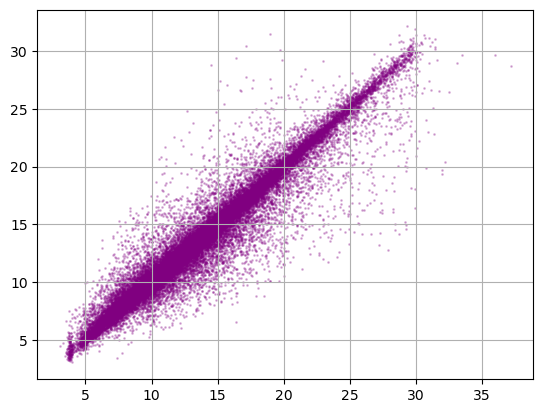

In [65]:
plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=1, color='purple', alpha=0.25)
plt.grid()
plt.show()

In [66]:
rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5

In [67]:
rmse

1.3054083662441371

In [68]:
(((ptestnn[:,:3] - ytest[:,:3])**2).mean(axis=1)**0.5 <= 3*rmse).sum()/ytest.shape[0]

0.9761226866830593

In [69]:
sklearn.metrics.r2_score(ytest, ptestnn, multioutput='raw_values')

array([0.88839601, 0.82302127, 0.84285542, 0.18702421, 0.10994523,
       0.27223875])

In [70]:
models_diccio['ann-sg'] = modelo_sg

### 6. Saving

In [72]:
for modelo in models_diccio.keys():

    if modelo.split('-')[0] == 'lr':
        pickle.dump(models_diccio[modelo], open(newpath + modelo + '.pkl', 'wb'))
    else:
        models_diccio[modelo].save(newpath + modelo + '.h5')
        
    np.save(newpath + modelo, diccio_ptest[modelo])